In [73]:
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
%matplotlib inline
numpy.random.seed(1239)

In [2]:
# Read the data
# Source: https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
raw_data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
#Check if any is nan. 
raw_data.isna().sum().sum()

0

In [4]:
def prepare_data(raw_data):
    labels = raw_data.Attrition == 'Yes'
    employee_data = raw_data.set_index('EmployeeNumber').drop(columns=['Attrition', 'EmployeeCount', 'Over18'])
    employee_data.loc[:, 'OverTime'] = employee_data.OverTime == 'Yes'
    employee_data = pd.get_dummies(employee_data)
    employee_data = pd.concat([employee_data.YearsAtCompany, employee_data.drop(columns='YearsAtCompany')], axis=1)
    return employee_data, labels


In [21]:
employee_data, labels = prepare_data(raw_data)
employee_data.OverTime = employee_data.OverTime.astype('float')
employee_data


,YearsAtCompany,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,6,41,1102,1,2,2,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
2,10,49,279,8,1,3,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
4,0,37,1373,2,2,4,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
5,8,33,1392,3,4,4,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
7,2,27,591,2,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0
8,7,32,1005,2,2,4,79,3,1,4,...,1,0,0,0,0,0,0,0,0,1
10,1,59,1324,3,3,3,81,4,1,1,...,1,0,0,0,0,0,0,0,1,0
11,1,30,1358,24,1,4,67,3,1,3,...,1,0,0,0,0,0,0,1,0,0
12,9,38,216,23,3,4,44,2,3,3,...,0,0,1,0,0,0,0,0,0,1


In [145]:
#Now scale the dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(employee_data.values.astype('float')), columns=employee_data.columns)
years_scaler = StandardScaler()
years_scaler.fit(employee_data.YearsAtCompany.values.astype('float').reshape(employee_data.values.shape[0],1));


Now we want to generate synthetic labels to test if our models works in a controlled environment. Let's assume, that the probability that a person quits is a constant and does not depend on any features. In this case the likelihood that the person has quit follows a geometric distribution. If our model can correctly find this probability *p* based on a synthetic labels, then we can try this model on real data. 

In [6]:
#pick a p
p = 0.1

In [11]:
def quit_after(years, p):
    '''
    Returns the likelihood that the person quits after the given number of years
    years -- nunber of years
    p -- probability that the person quits in a given year
    '''
    return numpy.random.rand(years.shape[0]) < (1-p)**(years-1)*p

In [8]:
synthetic_labels = quit_after(employee_data.YearsAtCompany, p).astype('float')

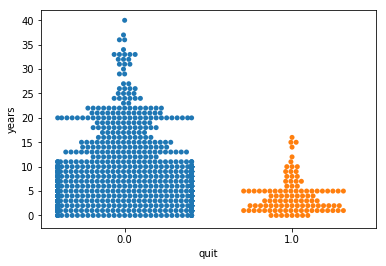

In [9]:
sns.swarmplot(y='years', x='quit', data=pd.DataFrame({"quit":synthetic_labels, 'years':employee_data.YearsAtCompany}))

Based on the chart it seems like a realistic data set.
Now we need to construct our loss function. It will have an additional parameter: number of years

We define probability $p(x, t)$ that the person quits this very day, where t is the number of years and x is the remaining features. Then the probabiity that the person has quit after the year $t$  is 
$$P(x,t) = (\prod_{l=0}^{t-1} (1-p(x,l))) p(x,t) $$ whereas the probability that the person will remain after the year $t$ is 
$$P(x,t) = \prod_{l=0}^{t} (1-p(x,l)) $$
Strictly speaking x is also dependent on t, but we don't have the historical data for this, so we assume that x is independent of t.

Using the principle of maximum likelihood, we derive the loss function taking negative log of the likelihood function:
$$\mathscr{L}(y,p) = -\sum_{l=0}^{t-1} \log(1-p(x,l)) - y \log{p} - (1-y) \log(1-p) $$
Where y is an indicator if the person has quit after working exactly t years or not.
Notice that the last two terms is the cross-entropy loss function, and the first term is a hitorical term. 

Let's calculate the gradient of this function
$$ \frac{\partial \mathscr L}{\partial p} = \sum_{l=0}^{t-1} \frac{1}{1-p(x,l)} -\frac{y}{p} + \frac{1-y}{1-p}$$

Assuming that $p(x,l)$ is a sigmoid function (for simplicity we include bias in the list of weights, and so the weight for the t parameter): $$p=\frac{1}{1 + e^{-\bf{w}\bf{x}}}$$
Then the derivative over parameter becomes  for the x other than t:
$$ \frac{\partial \mathscr L}{\partial w_i} = (\sum_{l=0}^{t-1} p(x,l) + p - y) * x_i $$
The gradient for the weight corresponding to t is
$$ \frac{\partial \mathscr L}{\partial w_t} = \sum_{l=0}^{t-1} p(x,l)l + (p - y) * t $$




In [188]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [189]:
#Add 1 to the employee data
scaled_data['Ones'] = np.ones(shape=[employee_data.shape[0],1])

In [190]:
def scale_year(years):
    return float(years_scaler.transform(float(years)))

In [218]:
def logit(x, w, years=None):
    '''
    If years is not given, then this is just a dot product of x and w
    If years is given, we have to adjust it to make sure the weight is multiplied by the current year, 
        not the final year
    
    IMPORTANT: This assumes that the weight for the temporal variable is w[0]
    TODO: Remove this assumption and allow to specify the index of the temporal variable
    '''
    return x @ w + ((scale_year(years)-x[0]) * w[0] if years != None else 0)

In [219]:
def loss(x, y, w, years):
    '''
    The loss function
    '''
    #The first term
    sum_loss = 0
    for l in np.arange(years):
        sum_loss -= np.log(1-sigmoid(logit(x, w, l)))
    logistic_prob = sigmoid(logit(x, w))
    return sum_loss - y * np.log(logistic_prob) - (1-y) * np.log(1-logistic_prob)

In [193]:
def gradient(x,y,w, years):
    'The gradient'
    sum_prop = 0
    weighted_sum = 0
    for l in np.arange(years):
        sum_prop += sigmoid(logit(x, w, l)) 
        weighted_sum += sigmoid(logit(x, w, l)) * scale_year(l)
    grad =  (sum_prop + sigmoid(logit(x, w)) - y) * x
    grad[0] = weighted_sum + (sigmoid(logit(x, w)) - y) * x[0]
    return grad
    

In [210]:
def one_pass(weights, step_size, feature_data, temporal_data, labels, l2_regularization):
    '''
    One pass of the gradient descent
    '''
    cost = 0
    num_examples = feature_data.shape[0]
    total_gradient = np.zeros(shape=feature_data.shape[1])
    for i in range(feature_data.shape[0]):
        cost += loss(feature_data.values[i], labels.values[i], weights, temporal_data.iloc[i])  / num_examples
        total_gradient += gradient(feature_data.values[i], labels.values[i], weights, temporal_data.iloc[i]) / num_examples
    
    reg_matrix = l2_regularization * np.eye(len(weights))
    reg_matrix[-1,-1] = 0
    
    cost += 1 / 2 *  weights.T @ reg_matrix @ weights
    total_gradient += reg_matrix @ weights
    
    return cost, weights - step_size * total_gradient
        

In [211]:
#Initialize weights
weights = np.zeros(shape=[employee_data.values.shape[1]])
epochs = 100
step = 0.5
l2 = 0.9
for epoch in range(epochs):
    cost, weights = one_pass(weights, step, scaled_data, employee_data.YearsAtCompany, synthetic_labels, l2)
    if epoch % 10 == 0:
        print('Cost %f' % cost)

Cost 5.550836
Cost 0.456146
Cost 0.422308
Cost 0.413001
Cost 0.409684
Cost 0.408344
Cost 0.407764
Cost 0.407501
Cost 0.407379
Cost 0.407322


In [212]:
#We will print the learned weights.
for column_num, column_name in enumerate(employee_data.columns):
    print(f'{column_name}: {weights[column_num]}')

YearsAtCompany: -0.011258309016254384
Age: -0.011020169886120009
DailyRate: -0.0010937625705216393
DistanceFromHome: -0.006915531934845443
Education: -0.008604098890733058
EnvironmentSatisfaction: -0.006655140076679214
HourlyRate: 0.006376696126478421
JobInvolvement: 0.00730815008065071
JobLevel: -0.030337827656463538
JobSatisfaction: -0.00037385178332966163
MonthlyIncome: -0.028950050222140658
MonthlyRate: 0.005536972853307166
NumCompaniesWorked: 0.01120735576629996
OverTime: 0.0014616385227418332
PercentSalaryHike: 0.00571036280944902
PerformanceRating: -0.00540594790272684
RelationshipSatisfaction: 0.005234269963952163
StandardHours: 0.0
StockOptionLevel: -0.00488972456858543
TotalWorkingYears: -0.03532739769357629
TrainingTimesLastYear: 0.009447459902100629
WorkLifeBalance: -0.0029413645594849264
YearsInCurrentRole: -0.06897764280647062
YearsSinceLastPromotion: -0.04914260512777012
YearsWithCurrManager: -0.06848301164190633
BusinessTravel_Non-Travel: -0.00461357091645237
BusinessTr

In [213]:
predicted_prob = pd.Series(logit(scaled_data.values, weights))
predicted_prob.describe()

count    1470.000000
mean       -4.537261
std         0.256120
min        -5.425510
25%        -4.698081
50%        -4.485444
75%        -4.340895
max        -4.074156
dtype: float64

In [217]:
#We expect this probability based on the synthesized data (but we are getting something else....)
prb = synthetic_labels.sum()/len(synthetic_labels)/employee_data.YearsAtCompany.mean()
prb

0.010483401281304603